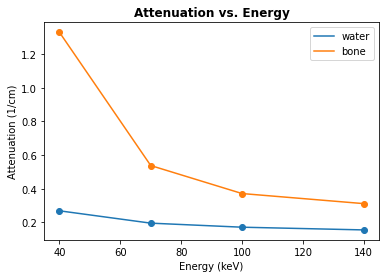

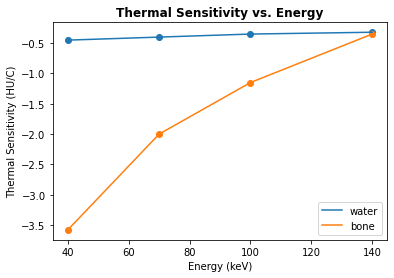

In [1]:
# DATA INITIALIZATION FOR MODEL
# - import attenuation vs. energy for water and bone
# - import thermal sensitivity vs. energy for water and bone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

# x_series: array of x values
# y_series: size n list of array of y values
# labels: size n list of labels corresponding to y_series
def line_plot(x_series, y_series, labels, title, ylabel, xlabel):
    for i in range(len(y_series)):
        plt.plot(x_series, y_series[i], label = labels[i])
        
    plt.title(title, fontweight='bold')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    
# annotate individual points
# for i in range(num_energy_levels):
#     x, y_w, y_b = energy_levels[i], water_attenuations[i], bone_attenuations[i]
#     plt.annotate(str("{:.2f}".format(y_w)), (x, y_w))
#     plt.annotate(str("{:.2f}".format(y_b)), (x, y_b))

# source: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html
df_bone = pd.read_excel('bone_attenuation_curve.xlsx')
df_water = pd.read_excel('water_attenuation_curve.xlsx')
x_bone = np.array(df_bone['energy (MeV)']) * 1000 # convert MeV to keV
y_bone = np.array(df_bone['mass attenuation (cm^2/g)'])
x_water = np.array(df_water['energy (MeV)']) * 1000
y_water = np.array(df_water['mass attenuation (cm^2/g)'])

water_attenuations = np.array([])
bone_attenuations = np.array([])

energy_levels = np.array([40, 70, 100, 140]) # in keV or kvP
num_energy_levels = energy_levels.size
bone_attenuations = np.interp(energy_levels, x_bone, y_bone) * 2 # density = 2g/cm^3
water_attenuations = np.interp(energy_levels, x_water, y_water)

# attenuation vs. energy for water and bone
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations],
          ['water', 'bone'], 
          'Attenuation vs. Energy',
          'Attenuation (1/cm)',
          'Energy (keV)')
plt.scatter(energy_levels, water_attenuations)
plt.scatter(energy_levels, bone_attenuations)
plt.show()

# source: https://link.springer.com/content/pdf/10.1007/s00330-021-08206-z.pdf       
water_alphas_HU = np.array([0.45, 0.4, 0.35, 0.32]) * -1
bone_alphas_HU = np.array([3.58, 2, 1.15, 0.35]) * -1

# convert thermal sensitivity from HU/C to mu/C (ie. 1/(C*cm))
water_alphas = (water_alphas_HU / 1000) * water_attenuations[0]
bone_alphas = (bone_alphas_HU / 1000) * water_attenuations[0]

# thermal sensitivity vs. energy for water and bone
line_plot(energy_levels, 
          [water_alphas_HU, bone_alphas_HU],
          ['water', 'bone'], 
          'Thermal Sensitivity vs. Energy',
          'Thermal Sensitivity (HU/C)',
          'Energy (keV)')
plt.scatter(energy_levels, water_alphas_HU)
plt.scatter(energy_levels, bone_alphas_HU)
plt.show()

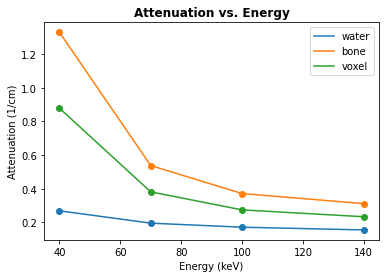

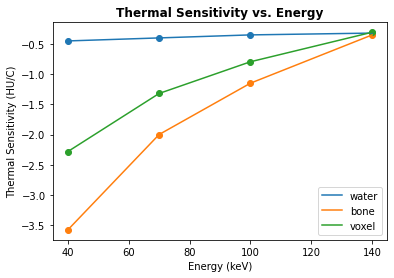

In [2]:
# GENERATE VOXEL
# - generates the attenuation and thermal sensitivity properties of a voxel
# - mu_voxel = V_w * mu_water + V_b * mu_bone                                      
# - alpha_voxel = V_w * alpha_w  + V_b * alpha_b where alpha has units of HU/C or 1/(cm * C) 

# generate the attenuation and thermal sensitivity properties of the voxel
def generate_voxel(V_w, V_b): 
    voxel_attenuations = V_w * water_attenuations + V_b * bone_attenuations
    voxel_alphas = V_w * water_alphas + V_b * bone_alphas
    voxel_alphas_HU = V_w * water_alphas_HU + V_b * bone_alphas_HU
                                       
    return voxel_attenuations, voxel_alphas, voxel_alphas_HU

# convert from HU to linear attenuation
def HU_to_mu(HU_values):
    return (HU_values / 1000) * water_attenuations[0] + water_attenuations[0]

# convert linear attenuation to HU
def mu_to_HU(attenuations):
    return ((attenuations - water_attenuations[0]) / water_attenuations[0]) * 1000

volume_fractions = np.array([0.3, 0.6, 0.1])
V_w = volume_fractions[0]
V_b = volume_fractions[1]
voxel_attenuations, voxel_alphas, voxel_alphas_HU = generate_voxel(V_w, V_b)
                                       
# attenuation vs. energy for voxel
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations, voxel_attenuations],
          ['water', 'bone', 'voxel'], 
          'Attenuation vs. Energy',
          'Attenuation (1/cm)',
          'Energy (keV)')
plt.scatter(energy_levels, water_attenuations)
plt.scatter(energy_levels, bone_attenuations)
plt.scatter(energy_levels, voxel_attenuations)
plt.show()

# thermal sensitivity vs. energy for voxel
line_plot(energy_levels, 
          [water_alphas_HU, bone_alphas_HU, voxel_alphas_HU],
          ['water', 'bone', 'voxel'], 
          'Thermal Sensitivity vs. Energy',
          'Thermal Sensitivity (HU/C)',
          'Energy (keV)')
plt.scatter(energy_levels, water_alphas_HU)
plt.scatter(energy_levels, bone_alphas_HU)
plt.scatter(energy_levels, voxel_alphas_HU)
plt.show()

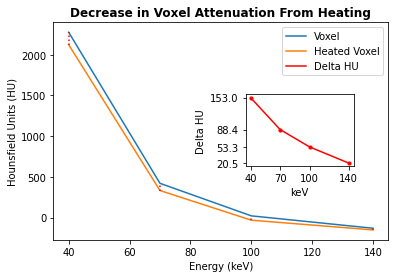

In [6]:
# HEAT VOXEL
# - decrease attenuation by alpha(E) times the change in temperature for each energy bin

# gt_temp: heated temperature
# voxel_attenuations obtained from generate_voxel()
# t0_temp = 23: default reference temperature
def heat_voxel(gt_temp, voxel_attenuations, t0_temp=23): 
    heated_voxel_attenuations = np.copy(voxel_attenuations)
    delta_T = gt_temp - t0_temp
    
    heated_voxel_attenuations += delta_T * voxel_alphas
    heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
    
    return heated_voxel_attenuations, heated_voxel_HU

gt_temp = 90
heated_voxel_attenuations, heated_voxel_HU = heat_voxel(gt_temp, voxel_attenuations)

voxel_HU = mu_to_HU(voxel_attenuations)
delta_HU = voxel_HU - heated_voxel_HU

# attenuation vs. energy plot before and after heating
fig, ax = plt.subplots()
ax.plot(energy_levels, voxel_HU, label = 'Voxel')
ax.plot(energy_levels, heated_voxel_HU, label = 'Heated Voxel')
ax.plot(40, 0, color='red', label='Delta HU')
plt.title('Decrease in Voxel Attenuation From Heating', fontweight='bold')
plt.ylabel('Hounsfield Units (HU)')
plt.xlabel('Energy (keV)')
plt.vlines(energy_levels, heated_voxel_HU, voxel_HU, colors='red', linestyle='dotted')
plt.legend()

ax_new  = fig.add_axes([0.57, 0.38, 0.25, 0.25]) # x_0, y_0, height, width
ax_new.plot(energy_levels, delta_HU, color='red')
plt.scatter(energy_levels, delta_HU, color='red', s=10)
plt.xticks(energy_levels)
plt.yticks(delta_HU)
plt.xlabel('keV')
plt.ylabel('Delta HU')
    
plt.show()

# line_plot(energy_levels, 
#           [delta_HU],
#           ['HU difference'], 
#           'change in voxel HU due to heating',
#           'HU',
#           'energy (keV)')
# plt.show()

In [139]:
# METHOD 1: TWO STEP ALGORITHM
# - computes material decomposition first and then predicts temperature separately
# - does not account for thermal error in material decomposition

volume_fractions = np.array([0.3, 0.7, 0])
V_w = volume_fractions[0]
V_b = volume_fractions[1]
voxel_attenuations, voxel_alphas, voxel_alphas_HU = generate_voxel(V_w, V_b)

gt_temp = 90
heated_voxel_attenuations, heated_voxel_HU = heat_voxel(gt_temp, voxel_attenuations)

error_level = 3
random_err = np.random.normal(0, error_level)
noisy_voxel_HU = heated_voxel_HU + random_err
voxel_HU = mu_to_HU(voxel_attenuations)

noisy_voxel_mu = HU_to_mu(noisy_voxel_HU) # mu domain for material_decomposition
noisy_delta_HU = voxel_HU - noisy_voxel_HU # HU domain for temperature_prediction
noisy_delta_mu = HU_to_mu(noisy_delta_HU)

def material_decomposition(temp):
    # perform linear temperature corrections to bone and water attenuations
    # temp=23 for two step algorithm
    corrected_water_mu = water_attenuations + water_alphas * (temp - 23)
    corrected_bone_mu = bone_attenuations + bone_alphas * (temp - 23)

    col_1 = np.expand_dims(corrected_water_mu, axis=1)
    col_2 = np.expand_dims(corrected_bone_mu, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    row_5 = np.expand_dims(np.ones(3), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0) # 5x3
    
    conditions = np.expand_dims(np.append(noisy_voxel_mu, 1), axis=1) # 5x1
    
    inverse = np.linalg.pinv(coefficient_mtx)

    volume_fractions = np.matmul(inverse, conditions) # 3x1
    V_w = volume_fractions[0]
    V_b = volume_fractions[1]
    
    return V_w, V_b
    
def temperature_prediction(V_w, V_b): 
    pred_temp_arr = np.array([])
    voxel_alphas_HU = V_w * water_alphas_HU + V_b * bone_alphas_HU # recomputed based on updated volume fractions
    pred_temp_arr = np.divide(-noisy_delta_HU, voxel_alphas_HU) + 23
    pred_temp = np.mean(pred_temp_arr)

    return pred_temp

def two_step_algorithm():
    V_w, V_b = material_decomposition(23)
    voxel_temp = temperature_prediction(V_w, V_b)
    
    return voxel_temp

# METHOD 2: ITERATIVE
# - T_n is our temperature prediction that becomes more accurate over each iteration
# - start with n = 0 and thus T_0 = 23 C
# - 1. perform material decomposition at T_n, obtaining V_wn and V_bn
# - 2. predict the temperature, T_(n+1)
# - 3. return to step 1 with T_n = T_(n+1)

# initialization
current_vars = [0, 0, 1]
penalty = 100

def f(current_vars):
    V_w = current_vars[0]
    V_b = current_vars[1]
    deltaT = current_vars[2]
    
    return (noisy_voxel_mu - V_w * water_attenuations - V_b * bone_attenuations
            - deltaT * (water_alphas + bone_alphas))

def J(current_vars):
    return np.mean(np.square(f(current_vars)))

def partialJ(current_vars, var):    
    V_w = current_vars[0]
    V_b = current_vars[1]
    deltaT = current_vars[2]
    
    if var == 'V_w':
        return (2 * np.multiply(f(current_vars), -water_attenuations) + penalty * 
               (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * -deltaT*water_alphas[0])
    elif var == 'V_b':
        return (2 * np.multiply(f(current_vars), -bone_attenuations) + penalty *
               (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * -deltaT*bone_alphas[0])
    elif var == 'deltaT':
        return (2 * np.multiply(f(current_vars), (water_alphas + bone_alphas)) + penalty *
               (noisy_delta_mu[0] - deltaT*water_alphas[0]*V_w - deltaT*bone_alphas[0]*V_b) * (-V_w * water_alphas[0] - V_b * bone_alphas[0]))
    
def iterative_descent(current_vars, LR):
    V_w = current_vars[0]
    V_b = current_vars[1]
    deltaT = current_vars[2]
    
    #print(partialJ(current_vars, 'V_w'))
    V_w2 = V_w - LR * np.mean(partialJ(current_vars, 'V_w'))
    #print(partialJ(current_vars, 'V_b'))
    V_b2 = V_b - LR * np.mean(partialJ(current_vars, 'V_b'))
    #print(partialJ(current_vars, 'deltaT'))
    deltaT2 = deltaT - LR * np.mean(partialJ(current_vars, 'deltaT'))
    
    current_vars = [V_w2, V_b2, deltaT2] # simultaneous update
    
    return current_vars

for i in range(1000):
    print(current_vars)
    current_vars = iterative_descent(current_vars, 0.2)
    print(current_vars)
    #print(J(current_vars))
    
# print(current_vars)
    
# def iterative_algorithm(threshold):
#     voxel_temp = 23
#     i = 0
#     delta_temp = 10 # arbitrary value greater than threshold

#     temp_iter_array = np.array([])
#     Vw_iter_array = np.array([])
#     Vb_iter_array = np.array([])
    
#     # while the adjustment in temperature prediction is significantly large
#     while(np.abs(delta_temp) > threshold):
#         V_w, V_b = material_decomposition(voxel_temp)
#         Vw_iter_array = np.append(Vw_iter_array, V_w)
#         Vb_iter_array = np.append(Vb_iter_array, V_b)

#         voxel_temp = temperature_prediction(V_w, V_b)
#         temp_iter_array = np.append(temp_iter_array, voxel_temp)

#         i += 1

#         if i > 1: 
#             delta_temp = temp_iter_array[i-1] - temp_iter_array[i-2]

#     return temp_iter_array[i-1]

# print(two_step_algorithm())
# print(iterative_algorithm(0.1))

# error_level = 5
# roi_temp_vals = np.array([])

# for i in range(100):
#     random_err = np.random.normal(0, error_level)
#     noisy_voxel_HU = mu_to_HU(heated_voxel_attenuations) + random_err
#     noisy_voxel_mu = HU_to_mu(noisy_voxel_HU) # material_decomposition
#     voxel_HU = mu_to_HU(voxel_attenuations)
#     noisy_delta_HU = voxel_HU - noisy_voxel_HU # temperature_prediction
    
#     temp_iter_array = iterative_algorithm(0.25)
#     iterations = temp_iter_array.size
    
#     roi_temp_vals = np.append(roi_temp_vals, temp_iter_array[iterations-1])

# print(np.mean(roi_temp_vals))
# print(np.std(roi_temp_vals) / 10)

[0, 0, 1]
[0.04213413925378006, 0.16343086968261156, 1.0001472464337846]
[0.04213413925378006, 0.16343086968261156, 1.0001472464337846]
[0.0742126352200792, 0.2869343435328228, 0.9992361505797046]
[0.0742126352200792, 0.2869343435328228, 0.9992361505797046]
[0.09868900657961402, 0.38025734548240564, 0.9975243837396173]
[0.09868900657961402, 0.38025734548240564, 0.9975243837396173]
[0.11741785016989154, 0.4507675023553749, 0.9952070187880945]
[0.11741785016989154, 0.4507675023553749, 0.9952070187880945]
[0.13180104138458662, 0.5040339408613254, 0.992431682285624]
[0.13180104138458662, 0.5040339408613254, 0.992431682285624]
[0.14289824680225, 0.544266312708289, 0.989310062187738]
[0.14289824680225, 0.544266312708289, 0.989310062187738]
[0.151510460214197, 0.5746466527621121, 0.9859266380413542]
[0.151510460214197, 0.5746466527621121, 0.9859266380413542]
[0.15824314699722913, 0.5975802291171114, 0.9823452983398477]
[0.15824314699722913, 0.5975802291171114, 0.9823452983398477]
[0.163553974

In [32]:
# METHOD 3: ONE STEP ALGORITHM
# - computes volume fractions and temperatures in single matrix system

volume_fractions = np.array([0.3, 0.6, 0.1])
V_w = volume_fractions[0]
V_b = volume_fractions[1]

gt_temp = 90
heated_voxel_attenuations, heated_voxel_HU = heat_voxel(gt_temp, voxel_attenuations)

error_level = 5
random_err = np.random.normal(0, error_level)
noisy_voxel_HU = heated_voxel_HU + random_err
voxel_HU = mu_to_HU(voxel_attenuations)

noisy_voxel_mu = HU_to_mu(noisy_voxel_HU) # mu domain for material_decomposition
noisy_delta_HU = voxel_HU - noisy_voxel_HU # HU domain for temperature_prediction

def one_step_algorithm():
    water_HU = mu_to_HU(water_attenuations)
    bone_HU = mu_to_HU(bone_attenuations)
    
    col_1 = np.expand_dims(water_HU, axis=1)
    col_2 = np.expand_dims(bone_HU, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1) - 1000 # HU of air is -1000
    col_4 = np.expand_dims(water_alphas_HU, axis=1)
    col_5 = np.expand_dims(bone_alphas_HU, axis=1)

    row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)
    
    coefficient_mtx = np.concatenate([col_1, col_2, col_3, col_4, col_5], axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0) # 5x5
#     print(coefficient_mtx.shape)
#     print('coefficients')
#     print(coefficient_mtx)
#     print('')

    conditions = np.expand_dims(np.append(noisy_voxel_HU, 1), axis=1) # 5x1 
#     print(conditions.shape)
#     print('conditions')
#     print(conditions)
#     print('')
    
    inverse = np.linalg.inv(coefficient_mtx)
#     print(inverse.shape)

    output = np.matmul(inverse, conditions) # 5x1
#     print('output')
#     print(output)
#     print('')

#     print(output[4]/output[1] + 23)
#     print(output[3]/output[0] + 23)
#     print('')
    
#     print('coefficient_mtx * output')
#     print(np.matmul(coefficient_mtx, output))
#     print('')
    
    V_w = output[0]
    V_b = output[1]
    gamma_1 = output[3] # gamma_1 = V_w * delta T
    gamma_2 = output[4] # gamma_2 = V_b * delta T
    temp1 = gamma_1 / V_w + 23
    temp2 = gamma_2 / V_b + 23
    
    # prevent exploding error at low volume fractions
    if V_w <= 0.1: 
        return  temp2
    elif V_b <= 0.1:
        return temp1
    else:
        return (temp1 + temp2) / 2
    
output = one_step_algorithm()

print(output)


[89.61268573]


In [39]:
# GENERATE STATISTICS
# global: water_attenuations, bone_attenuations, water_alphas_HU, bone_alphas_HU, water_alphas, bone_alphas

def generate_voxel(V_w, V_b): 
    voxel_attenuations = V_w * water_attenuations + V_b * bone_attenuations
    voxel_alphas = V_w * water_alphas + V_b * bone_alphas
    voxel_alphas_HU = V_w * water_alphas_HU + V_b * bone_alphas_HU
                                       
    return voxel_attenuations, voxel_alphas, voxel_alphas_HU

def heat_voxel(gt_temp, voxel_attenuations, t0_temp=23): 
    heated_voxel_attenuations = np.copy(voxel_attenuations)
    delta_T = gt_temp - t0_temp
    
    heated_voxel_attenuations += delta_T * voxel_alphas
    heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
    
    return heated_voxel_attenuations, heated_voxel_HU

percent_water = [1, 20, 40, 60, 80, 99]
error_levels = np.arange(0, 16, 1) # std. dev. of HU error

for k in percent_water:
    for error_level in error_levels:
        # col_1: ground truth temperature, col_2: ROI predicted temperature, col_3: stdev of col_2
        # col_4: MAE of temperature col_5: stdev of col_4
        data_file = np.empty((0, 3)) 

        temps = np.arange(23, 91, 1) # temperature of synthetic voxel

        for temp in temps:
            samples = 100 # number of pixels in 10x10 ROI

            pred_temp_arr = np.array([])
            AE_temp_arr = np.array([])
            # vol_frac_err_arr = np.array([])

            for i in range(samples):
                volume_fractions = np.array([k, 100-k, 0], dtype='float') / 100
                V_w = volume_fractions[0]
                V_b = volume_fractions[1]                
                voxel_attenuations, voxel_alphas, voxel_alphas_HU = generate_voxel(V_w, V_b)
                heated_voxel_attenuations, heated_voxel_HU = heat_voxel(temp, voxel_attenuations)

                random_err = np.random.normal(0, error_level)
                noisy_voxel_HU = heated_voxel_HU + random_err
                voxel_HU = mu_to_HU(voxel_attenuations)
                noisy_voxel_mu = HU_to_mu(noisy_voxel_HU) # mu domain for material_decomposition
                noisy_delta_HU = voxel_HU - noisy_voxel_HU # HU domain for temperature_prediction

                pred_temp = iterative_algorithm(0.1)
                pred_temp_arr = np.append(pred_temp_arr, pred_temp)
                # AE_temp_arr = np.append(AE_temp_arr, np.absolute(pred_temp - temp))
                # vol_frac_err_arr = np.append(vol_frac_err_arr, vol_frac_error)

            # temp loop
            avg_pred_temp = np.mean(pred_temp_arr)
            stdev_pred_temp = np.std(pred_temp_arr) 
            # MAE_temp = np.mean(np.absolute(AE_temp_arr))
            # stdev_MAE_temp = np.std(AE_temp_arr)

            data_row = np.expand_dims(np.array([temp, avg_pred_temp, stdev_pred_temp]), axis=0)
            data_file = np.append(data_row, data_file, axis = 0)  

        # error loop
        data_file
        df = pd.DataFrame(data_file)
        path = r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\iterative_algorithm\i_error_level_' + str(error_level) + '_percent_water_' + str(k) + '.xlsx'
        df.to_excel(excel_writer = path)

    # material loop
# outside loops

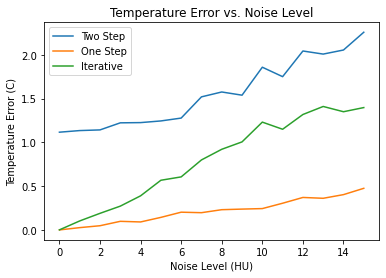

In [44]:
# INTER-METHOD VISUALIZATIONS

max_error = 16
error_level_x = np.arange(0, max_error, 1)
temp_error_all = np.empty((0, max_error))
stdev_all = np.empty((0, max_error))

k = 40 # 40% water, 60% bone
method_abbrv = ['2s', 'i', '1s']
method_names = ['two_step_algorithm', 'iterative_algorithm', 'one_step_algorithm']

for j in range(3):
    
    temp_error = np.array([])
    stdev = np.array([])
    
    for i in error_level_x:
        path = (r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\%s\%s_error_level_%s_percent_water_%s.xlsx' 
                % (str(method_names[j]), str(method_abbrv[j]), str(i), str(k)))
        
        df = pd.read_excel(path)
        df = df.drop('Unnamed: 0', axis=1)

        actual_temp = df[0]
        pred_temp = df[1]
    
        error = np.absolute(actual_temp - pred_temp)
        
        temp_error = np.append(temp_error, np.mean(error))
        stdev = np.append(stdev, np.std(error))
    
    temp_error = np.expand_dims(temp_error, axis=0)
    stdev = np.expand_dims(stdev, axis=0)
    
    temp_error_all = np.concatenate((temp_error_all, temp_error), axis=0)
    stdev_all = np.concatenate((stdev_all, stdev), axis=0)
    
error_2s = temp_error_all[0]
error_i = temp_error_all[1]
error_1s = temp_error_all[2]
    
plt.plot(error_level_x, error_2s, label = 'Two Step')
plt.plot(error_level_x, error_1s, label = 'One Step')
plt.plot(error_level_x, error_i, label = 'Iterative')
plt.legend()

plt.title('Temperature Error vs. Noise Level')
plt.ylabel('Temperature Error (C)')
plt.xlabel('Noise Level (HU)')

#ci = 1.96 * stdev
# ci = 0
# plt.fill_between(error_level_x, (mae_temp-ci), (mae_temp+ci), color='b', alpha=.1)

plt.show()

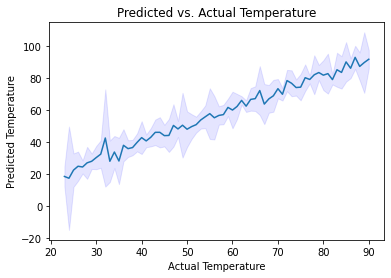

In [12]:
# INTRA-METHOD STATISTICS

i=2.0
path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + '.xlsx'
df = pd.read_excel(path)
df = df.drop('Unnamed: 0', axis=1)

actual_temp = df[0]
pred_temp = df[1]
stdev_pred_temp = df[2]
mae_temp = df[3]
mae_vol_frac = df[4]

ci = 1.96 * stdev_pred_temp

plt.plot(actual_temp, pred_temp)

plt.title('Predicted vs. Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.xlabel('Actual Temperature')

plt.fill_between(actual_temp, (pred_temp-ci), (pred_temp+ci), color='b', alpha=.1)

plt.show()